In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from tqdm.autonotebook import tqdm, trange
import cv2
import PIL
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time

In [2]:
class DocsDataset(Dataset):
    def __init__(self, dir, label, size):
        self.path = dir
        self.labels = label
        self.size = size
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        x = cv2.imread(str(self.path[idx]))
        label = self.labels[idx]
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        return x, label

    def _prepare_sample(self, image):
        image = cv2.resize(image, self.size)
        return np.array(image)

In [3]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [4]:
tz_dirs = list(Path("C:/Users/kirb2/Desktop/Diploma/ISP/train_sample/tz").glob('*'))
npa_dirs = list(Path("C:/Users/kirb2/Desktop/Diploma/ISP/train_sample/npa").glob('*'))
all_dirs = npa_dirs + tz_dirs
all_labels = [0] * len(npa_dirs) + [1] * len(tz_dirs)

In [5]:
from sklearn.model_selection import train_test_split

dirs_train, dirs_val, labels_train, labels_val = train_test_split(
    all_dirs, 
    all_labels, 
    test_size=0.3,
    random_state = 42)

In [6]:
train_data = DocsDataset(dirs_train, labels_train, size = (1654, 2339))
val_data = DocsDataset(dirs_val, labels_val, size = (1654, 2339))

In [7]:
dataloaders = {'train': DataLoader(train_data, batch_size=10, shuffle=True),
               'val': DataLoader(val_data, batch_size=10, shuffle=False)}
dataset_sizes = {'train': len(train_data), 'val': len(val_data)}

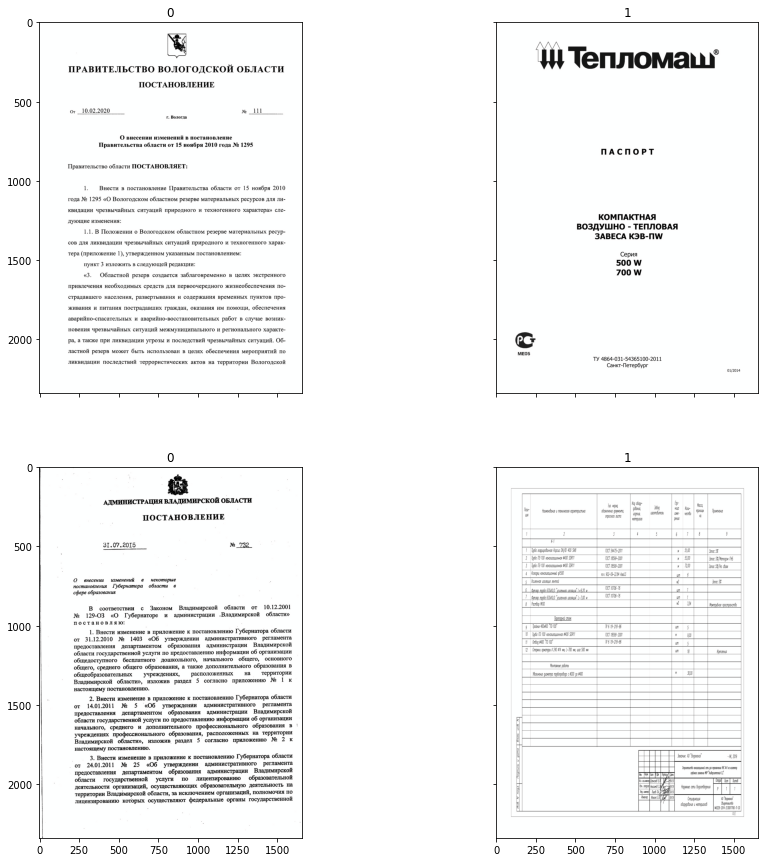

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15, 15),
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_docs = int(np.random.uniform(0, 683))
    im_train, label = train_data[random_docs]
    imshow(im_train.data.cpu(),
          title=label,plt_ax=fig_x)

In [9]:
class DocTypeNet(torch.nn.Module):
    def __init__(self):
        super(DocTypeNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=11),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=9),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.out = nn.Linear(19872, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = x.view(x.size(0), -1)

        x = self.out(x)
        return x

doctype = DocTypeNet() 

In [10]:
use_gpu = torch.cuda.is_available()
device = torch.device('cuda:0' if use_gpu else 'cpu')
doctype = doctype.to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(doctype.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #сохраним и загрузим лучшие веса модели
    torch.save(best_model_wts, 'doctype_net')
    model.load_state_dict(torch.load('doctype_net'))
    return model, losses

In [13]:
#doctype, losses = train_model(doctype, criterion, optimizer, scheduler=exp_lr_scheduler, num_epochs=7)

In [14]:
doctype.load_state_dict(torch.load("C:/Users/kirb2/Desktop/Diploma/ISP/Diploma_Task_win/doctype_net"))

<All keys matched successfully>

In [15]:
class SaveOutput:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []

In [16]:
save_output = SaveOutput()

hook_handles = []

for layer in doctype.modules():
    if isinstance(layer, nn.modules.conv.Conv2d):
        handle = layer.register_forward_hook(save_output)
        hook_handles.append(handle)

In [17]:
def module_output_to_numpy(tensor):
    return tensor.detach().to('cpu')

In [18]:
def visualise_save_pic(pic_name, pic_type):
    #plt.figure(figsize=(20, 20), frameon=False)
    for layer in range(len(save_output.outputs)):
        images = module_output_to_numpy(save_output.outputs[layer])
        for channel in range(len(images[0])):
            img = images[0][channel].numpy()
            img_uint = ((img - img.min())/(img.max() - img.min()) * 255).astype(np.uint8)
            #img_save = PIL.ImageOps.invert(Image.fromarray(img_uint)) #cv2
            #plt.imshow(img_save, cmap='gray', vmin=0, vmax=255)
            if not os.path.exists(f'C:/Users/kirb2/Desktop/Diploma/ISP/Diploma_Task_win/{layer+1}_layer/{pic_type}/{pic_name}'):
                os.makedirs(f'C:/Users/kirb2/Desktop/Diploma/ISP/Diploma_Task_win/{layer+1}_layer/{pic_type}/{pic_name}')
            os.chdir(f'C:/Users/kirb2/Desktop/Diploma/ISP/Diploma_Task_win/{layer+1}_layer/{pic_type}/{pic_name}')
            cv2.imwrite(f'{channel+1}_channel.jpg', img_uint)
            os.chdir('C:/Users/kirb2/Desktop/Diploma/ISP/Diploma_Task_win')

In [19]:
def pic_preparation(path):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ])
    x = cv2.imread(str(path))
    x = cv2.resize(x, (1654, 2339))
    x = np.array(x / 255, dtype='float32')
    x = transform(x)
    return x

for path in npa_dirs:
    picture = pic_preparation(path)
    out = doctype(picture.unsqueeze(0).to(device)).detach().cpu().numpy()
    visualise_save_pic(str(path)[-8:-4], 'npa')
    save_output.clear()

for path in tz_dirs:
    picture = pic_preparation(path)
    out = doctype(picture.unsqueeze(0).to(device)).detach().cpu().numpy()
    visualise_save_pic(str(path)[-8:-4], 'tz')
    save_output.clear()
    
print('Сохранение завершено')

Сохранение завершено
